In [10]:
#all the imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print(tf.__version__)

2.4.1


In [11]:
#Load the data
data= pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines = True)

# **preprocessing**

In [12]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [13]:
data.drop(columns="article_link")
#useless column for our case 

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [14]:
print("Null Values\n",data.isnull().sum())
print("\nData Shape: " , data.shape)

Null Values
 article_link    0
headline        0
is_sarcastic    0
dtype: int64

Data Shape:  (26709, 3)


In [15]:
X=data["headline"].tolist()
y=data["is_sarcastic"].tolist()

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True)

In [17]:
vocab_size=1000
embedding_dim=15
max_length=100
oov_token="<OOV>"

# **Tokenizing**

In [18]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index

In [19]:
list(word_index)[:10]

['<OOV>', 'to', 'of', 'the', 'in', 'for', 'a', 'on', 'and', 'with']

In [20]:
X_train_seq=tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_seq,maxlen=max_length,padding="post",truncating="post")

In [21]:
X_test_seq=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_seq,maxlen=max_length,padding="post",truncating="post")

In [22]:
x_train=tf.constant(X_train_pad)
x_test=tf.constant(X_test_pad)
y_train=tf.constant(y_train)
y_test=tf.constant(y_test)

2021-09-13 22:26:50.778862: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-13 22:26:50.782667: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 22:26:50.782705: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 22:26:50.782734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (453aa65a1f2d): /proc/driver/nvidia/version does not exist
2021-09-13 22:26:50.787819: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

# **Making the model**

In [23]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(96,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 15)           15000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 96)                1536      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 16,633
Trainable params: 16,633
Non-trainable params: 0
_________________________________________________________________


# **Training the model**

In [25]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if logs.get("val_accuracy")>0.8:
            print("\n reached 99% acc, cancelling training")
            self.model.stop_training=True 
callbacks=myCallback()

In [26]:
num_epochs=10000
history=model.fit(x_train,y_train,epochs=num_epochs,validation_split=0.2,verbose=2,callbacks=[callbacks])

2021-09-13 22:26:51.084651: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-13 22:26:51.100534: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/10000
535/535 - 2s - loss: 0.6520 - accuracy: 0.6049 - val_loss: 0.5444 - val_accuracy: 0.7131
Epoch 2/10000
535/535 - 1s - loss: 0.4436 - accuracy: 0.7953 - val_loss: 0.4178 - val_accuracy: 0.8102

 reached 99% acc, cancelling training


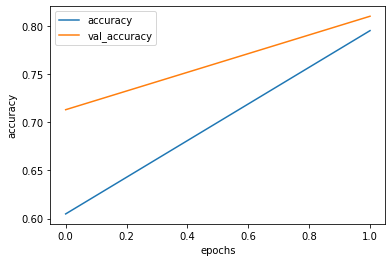

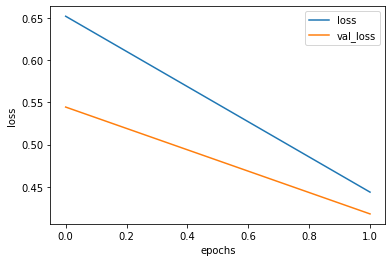

In [27]:
def plt_graph(history,val):
    plt.plot(history.history[val])
    plt.plot(history.history["val_"+val])
    plt.xlabel("epochs")
    plt.ylabel(val)
    plt.legend([val,"val_"+val])
    plt.show()
plt_graph(history,"accuracy")
plt_graph(history,"loss")

# **Testing the model**

In [28]:
y_pred=model.predict(x_test)

In [29]:
y_test=np.array(y_test)
y_pred = y_pred > 0.5

In [30]:
accuracy_score(y_test,y_pred,normalize=True)

0.8026956196181205